In [1]:
from optibook.synchronous_client import Exchange

import logging
logger = logging.getLogger('client')
logger.setLevel('ERROR')

print("Setup was successful.")

Setup was successful.


In [2]:
# Instrument aliases for readability
FOSSIL_BASKET = "C1_FOSSIL_FUEL_ETF"
FOSSIL_GAS = "C1_GAS_INC"
FOSSIL_OIL = "C1_OIL_CORP"

GREEN_BASKET = "C2_GREEN_ENERGY_ETF"
GREEN_SOLAR = "C2_SOLAR_CO"
GREEN_WIND = "C2_WIND_LTD"

In [3]:
e = Exchange()
e.connect()

2021-09-25 21:47:57,244 [asyncio   ] [MainThread  ] Using selector: EpollSelector


In [4]:
import sys
import numpy as np

def get_closing_price_sma_std(instrument_id, window):
    "Returns the last tick's closing price, and the moving mean and std for the given window."
    windowed_history = [t.price for t in  e.get_trade_tick_history(instrument_id)[-window:]]
    # TODO: fails if no history yet
    close_price = windowed_history[-1]
    return close_price, np.mean(windowed_history), np.std(windowed_history)

def get_bollinger_bands(mean, std):
    bollinger_up = mean + std * 2 # Calculate top band
    bollinger_down = mean - std * 2 # Calculate bottom band
    return bollinger_up, bollinger_down

In [5]:
closing_prices, bollingers = [], []

instrument_id = FOSSIL_OIL
window = 5

# Wait to get a trade tick before getting the initial values
while not e.poll_new_trade_ticks(instrument_id):
    continue

closing_price, mean, std = get_closing_price_sma_std(instrument_id, window)

i = 0
# I'd implement this as a class method, so that we can keep track with self.mean and self.std and
# just call the method when you need to check it, instead of the while True loop.
while True:
    i += 1
    # Skip when no new ticks
    if not e.poll_new_trade_ticks(instrument_id):
        continue
    
    print("iter", i)
    
    prev_mean, prev_std = mean, std
    closing_price, mean, std = get_closing_price_sma_std(instrument_id, window)
    
    # Spike - current std is twice bigger or smaller than the previous std
    if std > prev_std * 2 or prev_std > std * 2:
        mean = prev_mean
        print("Spike!")
    
    closing_prices.append(closing_price)
    bollingers.append(get_bollinger_bands(mean, std))
    print("Last closing price:", closing_price)
    print("Prev mean std:", prev_mean, prev_std)
    print("Current mean std:", mean, std)

iter 676103
Spike!
Last closing price: 230.0
Prev mean std: 230.10000000000002 0.0
Current mean std: 230.10000000000002 0.05000000000001137
iter 1194494
Spike!
Last closing price: 229.8
Prev mean std: 230.10000000000002 0.05000000000001137
Current mean std: 230.10000000000002 0.12472191289246776
iter 1917502
Last closing price: 229.60000000000002
Prev mean std: 230.10000000000002 0.12472191289246776
Current mean std: 229.87500000000003 0.1920286436967126
iter 2598644
Last closing price: 229.60000000000002
Prev mean std: 229.87500000000003 0.1920286436967126
Current mean std: 229.82000000000002 0.20396078054370761
iter 3955756
Last closing price: 230.10000000000002
Prev mean std: 229.82000000000002 0.20396078054370761
Current mean std: 229.82000000000002 0.20396078054370761
iter 4771920
Last closing price: 229.8
Prev mean std: 229.82000000000002 0.20396078054370761
Current mean std: 229.78000000000003 0.18330302779823307
iter 5319136
Last closing price: 229.8
Prev mean std: 229.78000000

KeyboardInterrupt: 

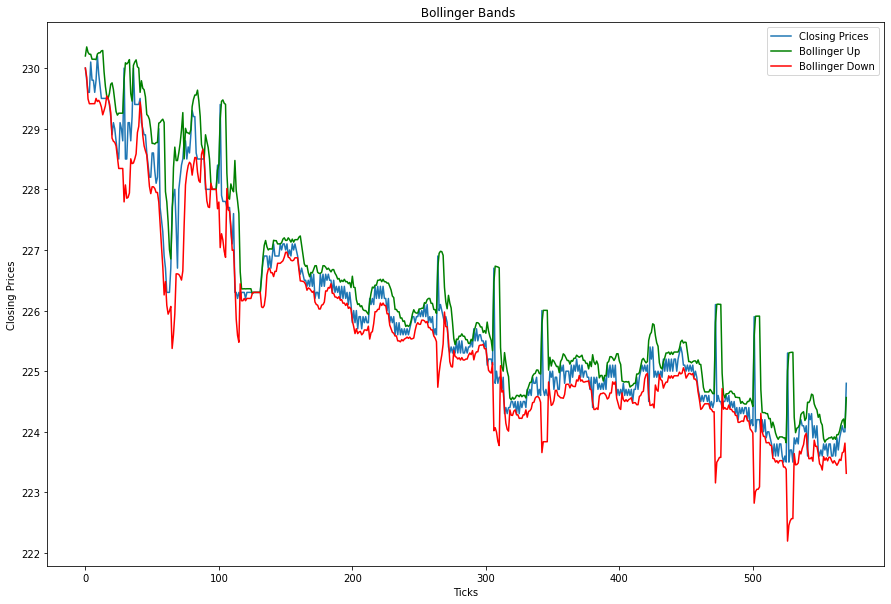

2021-09-25 22:03:37,161 [client    ] [Thread-4    ] Forcing a disconnect due to an error: Closing connection because someone else logged in with the same credentials. Only one session may be active at the same time.


In [12]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15,10))
plt.title(' Bollinger Bands')
plt.xlabel('Ticks')
plt.ylabel('Closing Prices')
plt.plot(closing_prices, label='Closing Prices')
plt.plot([b[0] for b in bollingers], label='Bollinger Up', c='g')
plt.plot([b[1] for b in bollingers], label='Bollinger Down', c='r')
plt.legend()
plt.show()